In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
def calculate_sortino_ratio(daily_returns, risk_free_rate=0.01):
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviatiaon = np.std(negative_returns, ddof=1)
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sortino_ratio = np.mean(excess_daily_returns) / downside_deviatiaon
    return sortino_ratio * np.sqrt(252)  # annualised

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns, ddof=1)
    return sharpe_ratio * np.sqrt(252)  # annualised

def calculate_maximum_drawdown(cumulative_returns):
    cumulative_returns = np.array(cumulative_returns) + 1
    if len(cumulative_returns) > 0:
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdowns = (running_max - cumulative_returns) / running_max
        max_drawdown = np.max(drawdowns)
        return max_drawdown
    else:
        return 0

def calculate_calmar_ratio(annual_return, max_drawdown):
    # if max_drawdown is negative, make it positive for the ratio
    return annual_return / abs(max_drawdown)

In [3]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')
# Jan to May (Train)
#data = data_read[data_read['DateTime_Minute'] <= '2025-05-31'].copy()
# June (Test)
data_test = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()


In [4]:
def run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation
    buy_signals = 0
    sell_signals = 0

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data_test['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.005
    exchange_fee_per_share = 0.003
    shares_per_transaction = 500

    look_ahead_window = 5 
    look_back_window = 20
  
    for i in range(look_back_window, len(data_test) - look_ahead_window):
        # Mid_price
        current_mid_price = data_test.iloc[i]['Mid-Price']
        future_prices = data_test.iloc[i+1:i+look_ahead_window+1]['Mid-Price']
        future_avg_price = future_prices.mean()
        current_RSI = data_test.iloc[i]['RSI']
        # Bid_ask_spread      
        bid_ask_spread_threshold = data_test.iloc[i-look_back_window:i]['Bid_Ask_Spread'].quantile(quantile_optimised)
        future_bid_ask = data_test.iloc[i+1:i+look_ahead_window+1]['Bid_Ask_Spread']
        future_bid_ask_avg = future_bid_ask.mean()
        is_liquid = future_bid_ask_avg <= bid_ask_spread_threshold

        if future_avg_price > current_mid_price * future_buy_increase and is_liquid and cash > 0 and current_RSI <= buy_threshold:
            # Buy condition
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            volume_ratio = (shares_to_buy) / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
            buy_signals += 1

        elif future_avg_price < current_mid_price * future_sell_decrease and is_liquid and shares_owned > 0 and current_RSI >= sell_threshold:
            # Sell condition
            shares_to_sell = min(shares_per_transaction, shares_owned)
            volume_ratio = shares_to_sell / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_to_sell - brokerage_fee_bps * adjusted_sell_price * shares_to_sell - exchange_fee_per_share * shares_to_sell
            cash += total_revenue
            transactions.append(('Sell', shares_to_sell, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0
            sell_signals += 1

        # Hold condition
        else: 
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Performance Metrics
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna() # daily returns from portfolio values
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data_test) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data_test)) - 1
    else:
        # cases where annual return cannot be computed
        annual_return = None
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data_test.iloc[-1]['Mid-Price']
    return initial_cash, final_valuation, final_valuation - initial_cash, transactions, buy_signals, sell_signals, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns

# optimised parameters
future_buy_increase = 1.01
future_sell_decrease = 0.97
quantile_optimised = 0.85
buy_threshold = 40
sell_threshold = 60

# Run simulation
results = []
initial_cash_test, final_valuation_test, profit_loss_test, transactions_test, buy_signals_test, sell_signals_test, sortino_ratio_test, sharpe_ratio_test, max_drawdown_test, calmar_ratio_test, daily_returns_test = run_trading_simulation(future_buy_increase, future_sell_decrease, quantile_optimised)

# Make trading signal 'Hold' as default
data_test['Trading Signal'] = 'Hold'
# update the DataFrame with transactions for training of RF
for transaction in transactions_test:
    signal_type, shares, price, cost, cash, day_index = transaction
    data_test.at[day_index, 'Trading Signal'] = signal_type

# Append results to a list
results.append((future_buy_increase, future_sell_decrease, quantile_optimised, profit_loss_test, len(transactions_test), buy_signals_test, sell_signals_test, sortino_ratio_test, sharpe_ratio_test, max_drawdown_test, calmar_ratio_test))

# Output results
results_df = pd.DataFrame(results, columns=['Future Buy Increase', 'Future Sell Decrease', 'Bid Ask Spread Threshold', 'Profit/Loss', 'Number of Transactions', 'Number of Buy Signals', 'Number of Sell Signals', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
results_df.to_csv('June Trading Simulation Results + RSI.csv')

# Output data_test with signals
data_test.to_csv('June Data with Trading Signals + RSI.csv') 

results_df.head(50)

,Future Buy Increase,Future Sell Decrease,Bid Ask Spread Threshold,Profit/Loss,Number of Transactions,Number of Buy Signals,Number of Sell Signals,Sortino Ratio,Sharpe Ratio,Max Drawdown,Calmar Ratio
0,1.01,0.97,0.85,60113.966752,10685,73,52,0.892815,0.588947,0.517914,0.132503


In [8]:
daily_returns_test
returns = (1 + daily_returns_test).cumprod() - 1
returns

1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
           ...   
10680    6.011397
10681    6.011397
10682    6.011397
10683    6.011397
10684    6.011397
Length: 10684, dtype: float64

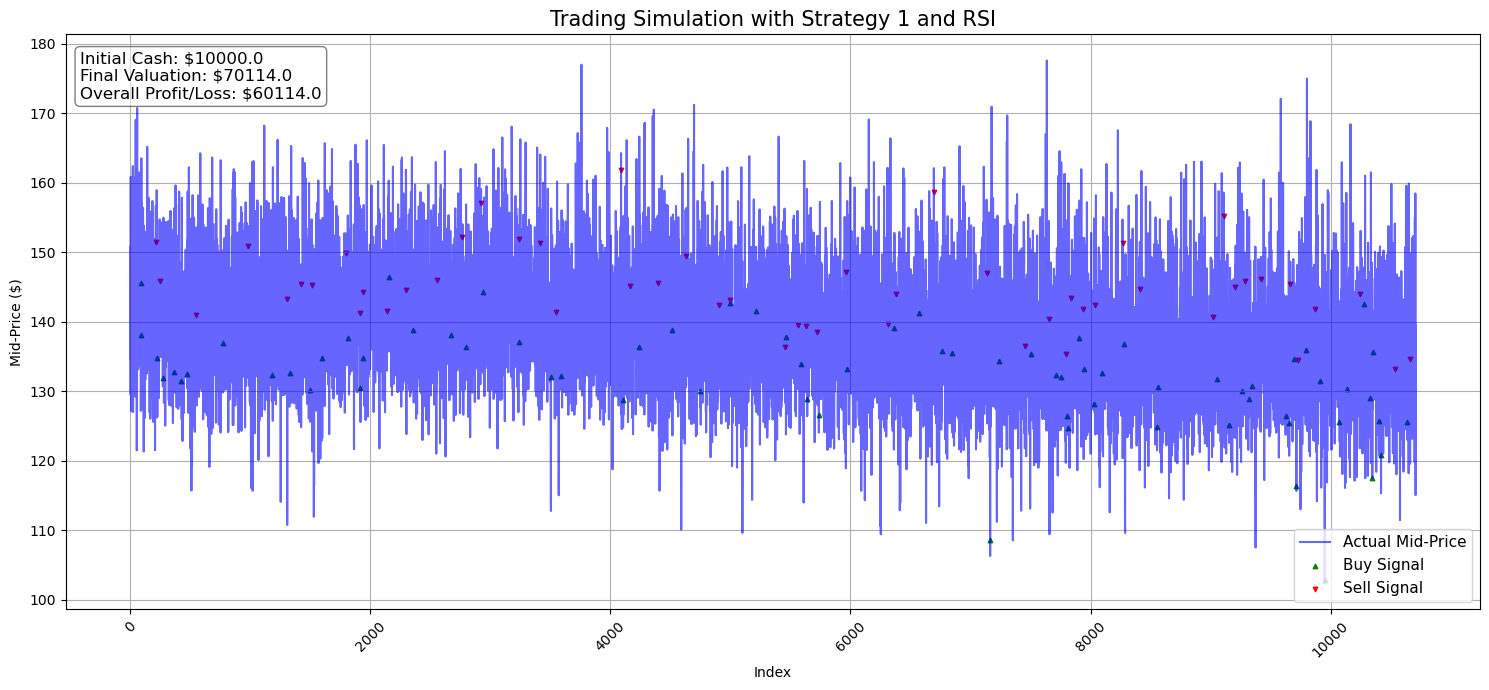

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Reset the index of data_test to a simple integer range
data_test.reset_index(drop=False, inplace=True)

# Assuming transactions_test_df already has the transactions with indices that match the new index of data_test
transactions_test_df = pd.DataFrame(transactions_test, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data_test.index, data_test['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)

# Filter transactions by Action to separate buys and sells
buy_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Buy']
sell_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Sell']

# Plotting the buy and sell signals using the index
ax.scatter(buy_signals_test['Time'], buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1.0)
ax.scatter(sell_signals_test['Time'], sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1.0)

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Initial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Text positioning on the axes
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Strategy 1 and RSI', fontsize=15)
ax.set_xlabel('Index')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

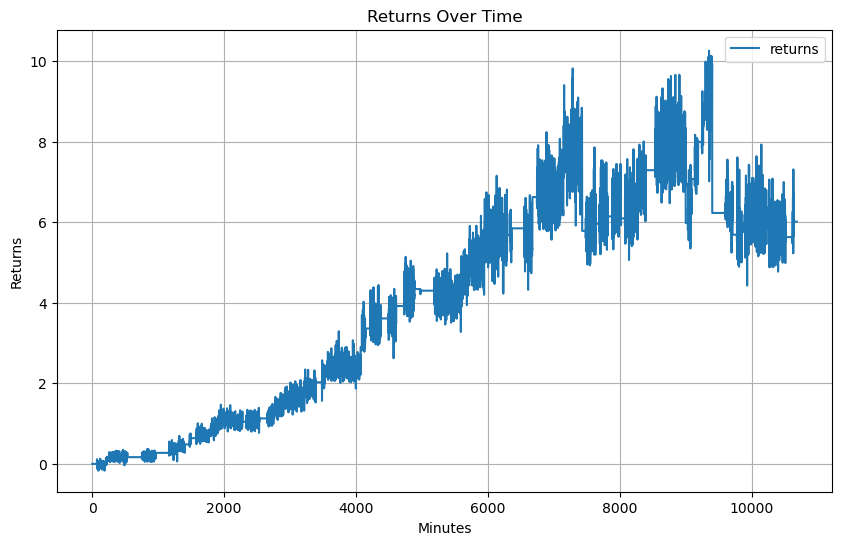

In [7]:

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(returns, label='returns')
plt.title('Returns Over Time')
plt.xlabel('Minutes')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


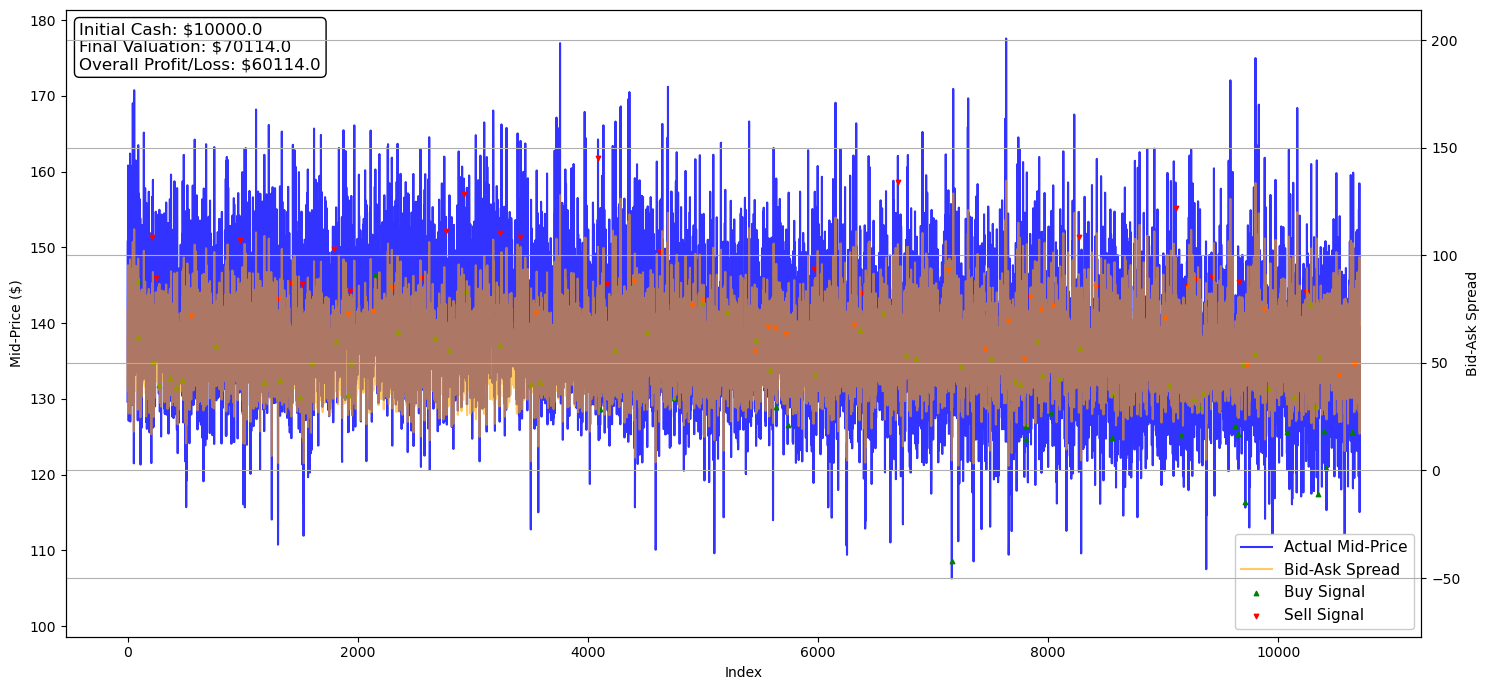

In [9]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Reset the index of data_test to a simple integer range (if needed)
#data_test.reset_index(drop=False, inplace=True)

# Plotting Mid-Price on the primary y-axis
line1, = ax1.plot(data_test.index, data_test['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.8, zorder=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Mid-Price ($)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Bid-Ask Spread
ax2 = ax1.twinx()
line2, = ax2.plot(data_test.index, data_test['Bid_Ask_Spread'], label='Bid-Ask Spread', color='orange', alpha=0.6, zorder=2)
ax2.set_ylabel('Bid-Ask Spread', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the scale of the Bid-Ask Spread axis if needed
min_spread = data_test['Bid_Ask_Spread'].min()
max_spread = data_test['Bid_Ask_Spread'].max()
spread_range = max_spread - min_spread
ax2.set_ylim([min_spread - 0.6 * spread_range, max_spread + 0.6 * spread_range])

# Filter transactions by Action to separate buys and sells
buy_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Buy']
sell_signals_test = transactions_test_df[transactions_test_df['Action'] == 'Sell']

# Plotting the buy and sell signals using the index
buy_scatter = ax1.scatter(buy_signals_test['Time'], buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1, zorder=4)
sell_scatter = ax1.scatter(sell_signals_test['Time'], sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1, zorder=5)

# Ensuring ax2 is visually on top for clarity
ax2.set_zorder(ax1.get_zorder() + 1)
ax1.patch.set_visible(False)  # Make ax1 background transparent

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Initial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=1)
# Text positioning on the axes
ax1.text(0.01, 0.98, text_str, transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=props)

# Legend
legend_handles = [line1, line2, buy_scatter, sell_scatter]
legend = ax1.legend(handles=legend_handles, loc='lower right', fontsize=11)
legend.get_frame().set_alpha(1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

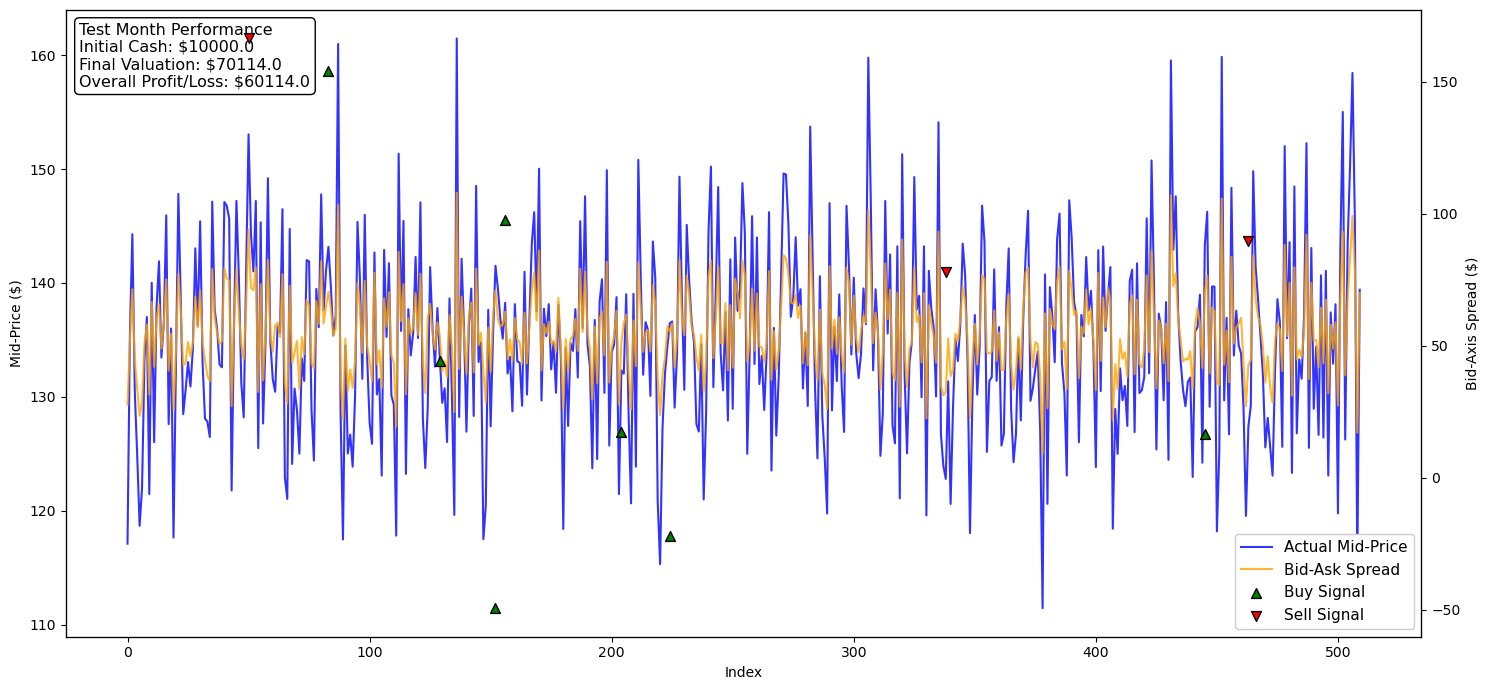

In [11]:
import matplotlib.pyplot as plt

# Assuming data_read and transactions_test_df have been defined and processed elsewhere in your code.

# Preparation of the data
data_week = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()
data_test_lastday = data_week.tail(510)
data_test_lastday.reset_index(drop=True, inplace=True)

transactions_test_lastday = transactions_test_df.tail(510)
transactions_test_lastday.reset_index(drop=True, inplace=True)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Filter transactions by Action to separate buys, sells, and holds
buy_signals_test = transactions_test_lastday[transactions_test_lastday['Action'] == 'Buy']
sell_signals_test = transactions_test_lastday[transactions_test_lastday['Action'] == 'Sell']

# Plotting the Mid-Price line on ax1
line1, = ax1.plot(data_test_lastday.index, data_test_lastday['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.8, zorder=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Mid-Price ($)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Bid-Ask Spread
ax2 = ax1.twinx()
line2, = ax2.plot(data_test_lastday.index, data_test_lastday['Bid_Ask_Spread'], label='Bid-Ask Spread', color='orange', alpha=0.8, zorder=2)
ax2.set_ylabel('Bid-Axis Spread ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adjust the scale for the Bid-Ask Spread axis
min_spread = data_test_lastday['Bid_Ask_Spread'].min()
max_spread = data_test_lastday['Bid_Ask_Spread'].max()
spread_range = max_spread - min_spread
ax2.set_ylim([min_spread - 0.7 * spread_range, max_spread + 0.7 * spread_range])

# Plotting the phantom axis for markers
ax_markers = ax1.twinx()
ax_markers.set_yticks([])  # Hide y-axis ticks and labels
ax_markers.set_ylabel('')  # Hide y-axis label

# Plotting the buy and sell signals markers on ax_markers
buy_scatter = ax_markers.scatter(buy_signals_test.index, buy_signals_test['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1, zorder=4, edgecolor='black')
sell_scatter = ax_markers.scatter(sell_signals_test.index, sell_signals_test['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1, zorder=4, edgecolor='black')

# Add labels with model results
final_valuation_test = final_valuation_test  # assume calculated elsewhere in your simulation function
initial_cash_test = initial_cash_test  # assume defined elsewhere in your function
text_str = f'Test Month Performance\nInitial Cash: ${initial_cash_test:.1f}\nFinal Valuation: ${final_valuation_test:.1f}\nOverall Profit/Loss: ${final_valuation_test - initial_cash_test:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=1)
# Text positioning on the axes
ax2.text(0.01, 0.98, text_str, transform=ax1.transAxes, fontsize=11.5, verticalalignment='top', bbox=props)

# Legend
legend_handles = [line1, line2, buy_scatter, sell_scatter]
legend = ax1.legend(handles=legend_handles, loc='lower right', fontsize=11)
legend.get_frame().set_alpha(1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()